## Generating data from a A/V file
(the hacky-programming way)
1. Copy [openPoseCV](https://opencv.org/) [pre-trained coefficients](https://github.com/CMU-Perceptual-Computing-Lab/openpose).
2. Detect and create pose data from webcam/file.
4. Install and import [Librosa](https://librosa.github.io/librosa/index.html).
3. Detect audio and create data from mic/file.
5. Export to csv

In [1]:
import cv2
import time
import numpy as np
import pandas as pd
from time import clock #if we've to time it
from PIL import Image #justINcase
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mode = 'COCO'
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"
nPoints = 18
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

In [3]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
inWidth = 368
inHeight = 368

### Example:

In [4]:
# sample image of a beautiful human
frame = cv2.imread("single.jpg") 

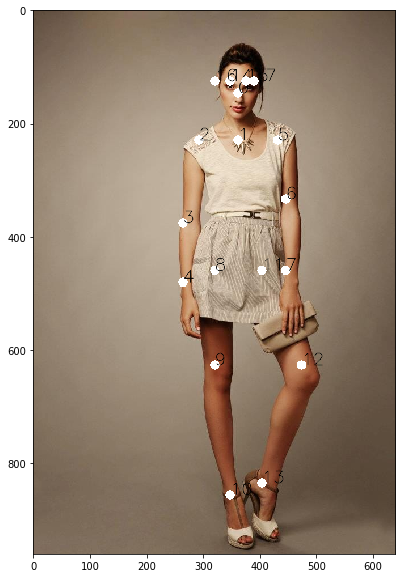

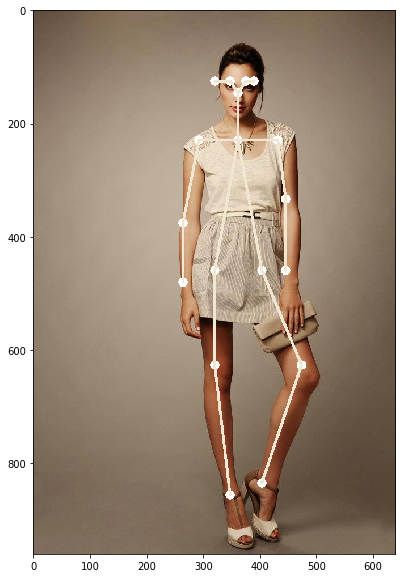

In [5]:
def process_image(frame):
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),(0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)

    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    # Empty list to store the detected keypoints
    points = []

    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (255, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 8, (255, 255, 255), thickness=-1, lineType=cv2.FILLED)

            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (210, 230, 240), 3)

#     plt.figure(figsize=[10,10])
#     plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
#     plt.figure(figsize=[10,10])
#     plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return (points, frameCopy, frame)
turd_variable, frame_c, frame = process_image(frame)
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB))
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

**Let's run the above function over a cropped compilation of videos**

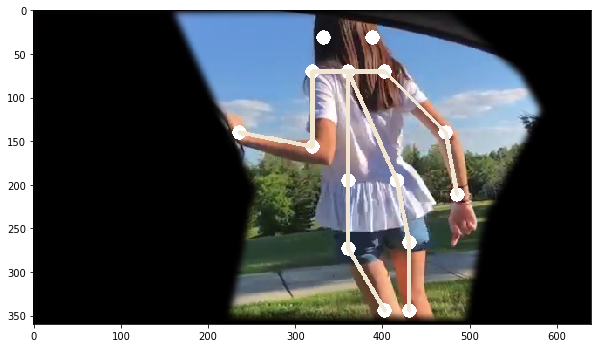

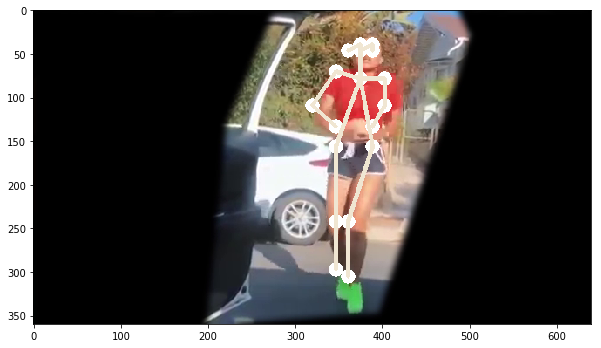

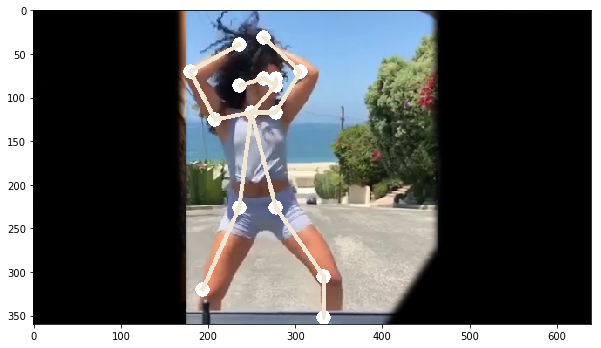

In [6]:
cap = cv2.VideoCapture('trainV.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
r_points=[]
# eta = []
# while(cap.isOpened()):
for i in range(n_frames):
    ret, image = cap.read()
    image_orig = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     start = clock()
    points, frame_c, frame = process_image(image)
    r_points.append(points)
#     stop = clock()
#     took = stop-start
#     eta.append(took)
#     plt.figure(figsize=[10,10])
#     plt.imshow(cv2.cvtColor(frame_c, cv2.COLOR_BGR2RGB))
    if i == 1 or i == int(n_frames/2) or i == n_frames-1:
        plt.figure(figsize=[10,10])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
cap.release()
cv2.destroyAllWindows()

In [7]:
r_pointsnp = np.array(r_points)
r_pointsnp.shape

(2266, 18)

In [8]:
df = pd.DataFrame(r_pointsnp.T)
df.to_csv('ytrain.csv')
#We've a set of points corresponding to each frame

# Audio data

In [3]:
cap = cv2.VideoCapture('trainV.mp4')
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
import librosa
y, sr = librosa.load('trainA.wav')
print(type(y),'samplerate = ',sr)
duration = librosa.get_duration(y,sr)
tempoG = librosa.feature.tempogram(y=y, sr=sr, hop_length=int((sr*duration)/n_frames), win_length=5)
#generating tempogram cause whynot

<class 'numpy.ndarray'> samplerate =  22050


In [4]:
df_audio = pd.DataFrame(tempoG)
df_audio.to_csv('xtrain.csv')
#we've audio data to train